In [17]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re

from utils import below_threshold_len

import kobert

/home/masang/anaconda3/envs/kobert/lib/python3.9/site-packages/mxnet/numpy/utils.py:37: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  bool = onp.bool


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

#### 전처리 & train / val split

In [4]:
# load preprocessed amazon review dataset from directory
train_data = pd.read_csv("data/preprocessed_combined_train.csv")
print('전체 샘플수 :', (len(train_data)))

전체 샘플수 : 4828


텍스트의 최소 길이 : 9
텍스트의 최대 길이 : 239
텍스트의 평균 길이 : 53.5735294117647


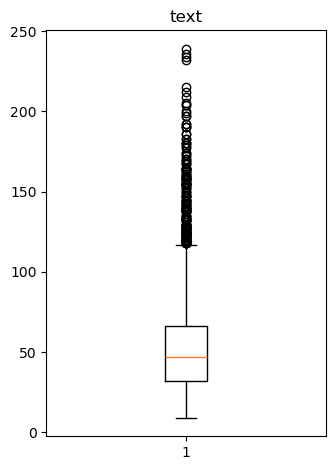

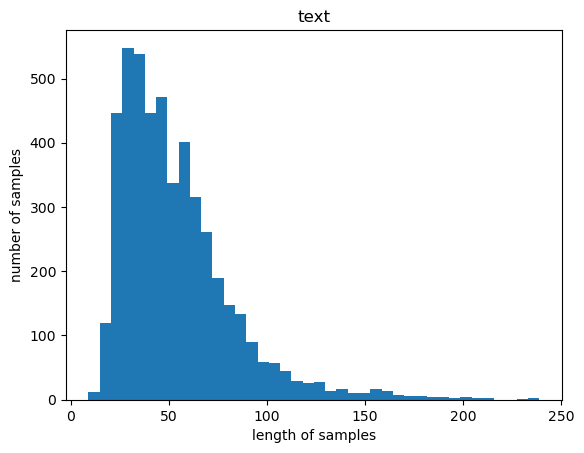

In [5]:
text_len = [len(s.split()) for s in train_data['conversation']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [6]:
# mean + 2*std를 텍스트 길이의 상한선으로 설정 -> 손실되는 text 5% 미만
text_max_len = int(np.mean(text_len) + 2 * np.std(text_len))
print(text_max_len)

111


In [7]:
below_threshold_len(text_max_len, train_data['conversation'])

전체 샘플 중 길이가 111 이하인 샘플의 비율: 0.9571251035625518


In [8]:
train_data = train_data[train_data["conversation"].apply(lambda x: len(x.split()) <= text_max_len)]

print('전체 학습 샘플수 :', (len(train_data)))

전체 학습 샘플수 : 4621


In [9]:
label_mapping = {
    '협박 대화': 0,
    '기타 괴롭힘 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '갈취 대화': 3,
    '일반 대화': 4
}

train_data['class'] = train_data['class'].map(label_mapping)

In [10]:
x_train = np.array(train_data['conversation'])
y_train = np.array(train_data['class'])

In [11]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

In [12]:
print('훈련 데이터의 개수 :', len(x_train))
print('훈련 레이블의 개수 :', len(x_val))
print('테스트 데이터의 개수 :', len(y_train))
print('테스트 레이블의 개수 :', len(y_val))

훈련 데이터의 개수 : 3696
훈련 레이블의 개수 : 925
테스트 데이터의 개수 : 3696
테스트 레이블의 개수 : 925


#### 텍스트 데이터 토큰화 & 패딩

In [11]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(x_train)

In [12]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 22736
등장 빈도가 2번 이하인 희귀 단어의 수: 16132
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 6604
단어 집합에서 희귀 단어의 비율: 70.95355383532723
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 10.631751263338279


In [13]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=6600)
tokenizer.fit_on_texts(x_train)
tokenizer.fit_on_texts(x_val)

In [14]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
x_train_tk = tokenizer.texts_to_sequences(x_train)
x_val_tk = tokenizer.texts_to_sequences(x_val)

# 잘 진행되었는지 샘플 출력
print(x_train_tk[:3])

[[909, 2677, 16, 2, 23, 25, 8, 599, 149, 197, 429, 1017, 1177, 2950, 1220, 1809, 2951, 66, 161, 3, 2, 1435, 1220, 528, 481, 19, 42, 219, 909, 2677, 16, 581, 259, 67, 2952, 574, 2, 529, 19, 42, 838, 3651, 1918, 4886, 246, 283, 530, 1368], [2033, 2465, 4887, 78, 46, 78, 14, 482, 78, 127, 1919, 5, 541, 373, 2157, 2, 35, 2, 35, 4147, 2158, 6000, 2678, 113, 2465, 4888, 1436, 4, 26, 48, 839, 10, 46, 482, 40, 1920, 10, 78, 26, 2, 35, 48, 88, 1810, 47, 3, 158, 60, 289, 113, 196, 6, 2953, 33, 52, 267, 6001, 44, 5, 6, 300, 1104, 6, 2954, 1, 430, 2466, 82, 840, 1105, 52, 4148, 78, 14, 2034], [2035, 72, 27, 397, 1018, 28, 142, 8, 139, 1437, 72, 225, 500, 1723, 2, 6002, 11, 1141, 27, 208, 2, 938]]


In [15]:
x_train_tk = tf.keras.utils.pad_sequences(x_train_tk, maxlen=text_max_len, padding='post')
x_val_tk = tf.keras.utils.pad_sequences(x_val_tk, maxlen=text_max_len, padding='post')

#### 모델 초기화 & 학습

In [16]:
vocab_size = 6600    # 어휘 사전의 크기입니다(3~9999의 인덱스 범위)
embed_dim = 256  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# lstm model
lstm = tf.keras.Sequential()
lstm.add(tf.keras.layers.Embedding(vocab_size, embed_dim, input_shape=(None,)))
lstm.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
lstm.add(tf.keras.layers.Dense(64, activation='relu'))
lstm.add(tf.keras.layers.Dense(5, activation='softmax'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

lstm.summary()

/home/masang/anaconda3/envs/tfenv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1739943679.756067   62832 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1739943679.787651   62832 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1739943679.789380   62832 cuda_executor.cc:1015] successful NUMA node rea

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, None, 256)      │     1,689,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,862,533 (7.10 MB)

 Trainable params: 1,862,533 (7.10 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("models/.weights.h5", 
                             monitor='val_accuracy', 
                             verbose=1,
                             save_best_only=True,
                             mode='max', 
                             save_weights_only=True)

In [18]:
lstm.compile(optimizer=tf.keras.optimizers.Adam(0.0002),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epochs = 50

history = lstm.fit(x_train_tk,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val_tk, y_val),
                    verbose=1,
                    callbacks=[checkpoint])

Epoch 1/50


2025-02-19 14:41:21.373348: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101


5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2190 - loss: 1.6080
Epoch 1: val_accuracy improved from -inf to 0.39135, saving model to models/.weights.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.2303 - loss: 1.6066 - val_accuracy: 0.3914 - val_loss: 1.6009
Epoch 2/50
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4425 - loss: 1.5948
Epoch 2: val_accuracy improved from 0.39135 to 0.41081, saving model to models/.weights.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4386 - loss: 1.5937 - val_accuracy: 0.4108 - val_loss: 1.5908
Epoch 3/50
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4585 - loss: 1.5794
Epoch 3: val_accuracy improved from 0.41081 to 0.50054, saving model to models/.weights.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4676 - loss: 1.5783 - val_accuracy: 0.5005 - val_loss: 1.5756
Epoch 4/50
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5507 - loss: 1.5601
Epoch 4: val_accuracy improved from 0.50054 to 0.50703, saving mode